In [4]:
import warnings

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OrdinalEncoder, PolynomialFeatures


warnings.filterwarnings('ignore')
np.random.seed(0)

In [5]:
full_data = pd.read_csv("../data/raw/data-inputing-prediction-without-nulls.csv")
missing_data = pd.read_csv("../data/raw/data-inputing-predicting-with-nulls.csv")

full_data = full_data.drop(columns=['Unnamed: 0'], inplace=False)
missing_data = missing_data.drop(columns=['Unnamed: 0'], inplace=False)

missing_data = missing_data.rename(columns={"0": "datetime",
                                            '1': 'feature1',
                                            '2': "feature2",
                                            '3': 'feature3'})

datetime_encoder = OrdinalEncoder()
missing_data['datetime'] = datetime_encoder.fit_transform(
    missing_data[['datetime']])
full_data['datetime'] = datetime_encoder.transform(full_data[['datetime']])

In [6]:
missing_data.head(5)

'|    |   datetime |   feature1 |   feature2 |   feature3 |\n|---:|-----------:|-----------:|-----------:|-----------:|\n|  0 |        967 |    25.6189 |  -0.932839 |   3.90016  |\n|  1 |        836 |    28.5598 |  -1.17187  |   0.223089 |\n|  2 |       1168 |    31.3903 |   0.82609  |   2.06954  |\n|  3 |        344 |    14.2057 |  -0.921493 |   1.2074   |\n|  4 |        939 |    25.0476 |   0.294643 |   4.73171  |'

In [4]:
train_data = missing_data[~pd.isna(missing_data.feature1)]
val_data = full_data[pd.isna(missing_data.feature1)]

In [5]:
print(train_data.head())
print(len(train_data))

   datetime   feature1  feature2  feature3
0     967.0  25.618887 -0.932839  3.900162
1     836.0  28.559832 -1.171867  0.223089
2    1168.0  31.390287  0.826090  2.069539
3     344.0  14.205741 -0.921493  1.207404
4     939.0  25.047604  0.294643  4.731710
1417


In [6]:
print(val_data.head())
print(len(val_data))

    datetime   feature1  feature2  feature3
12      12.0   8.134042  0.492448  0.962989
30      30.0  10.039666  1.005823  2.173050
32      32.0   7.303155  1.009762  2.253212
36      36.0   7.430519  1.096115  2.491071
47      47.0   9.187427  0.505252  2.309306
583


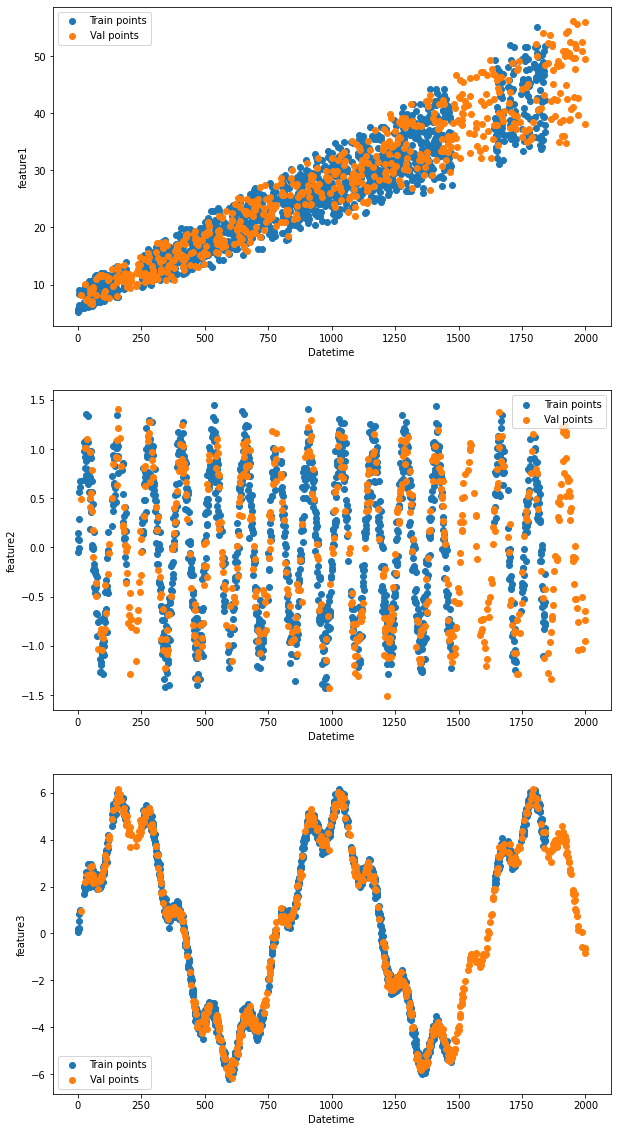

In [7]:
# Visualization
fig, axes = plt.subplots(3, 1, figsize=(10, 20))

for ii, column in enumerate(full_data.columns[1:]):
    axes[ii].scatter(x=train_data.datetime,
                     y=train_data[column], label="Train points")
    axes[ii].scatter(x=val_data.datetime,
                     y=val_data[column], label="Val points")
    axes[ii].set_xlabel("Datetime")
    axes[ii].set_ylabel(column)
    axes[ii].legend()

plt.show()
fig.savefig("../figures/data-inputing-visualization-dataset.png")

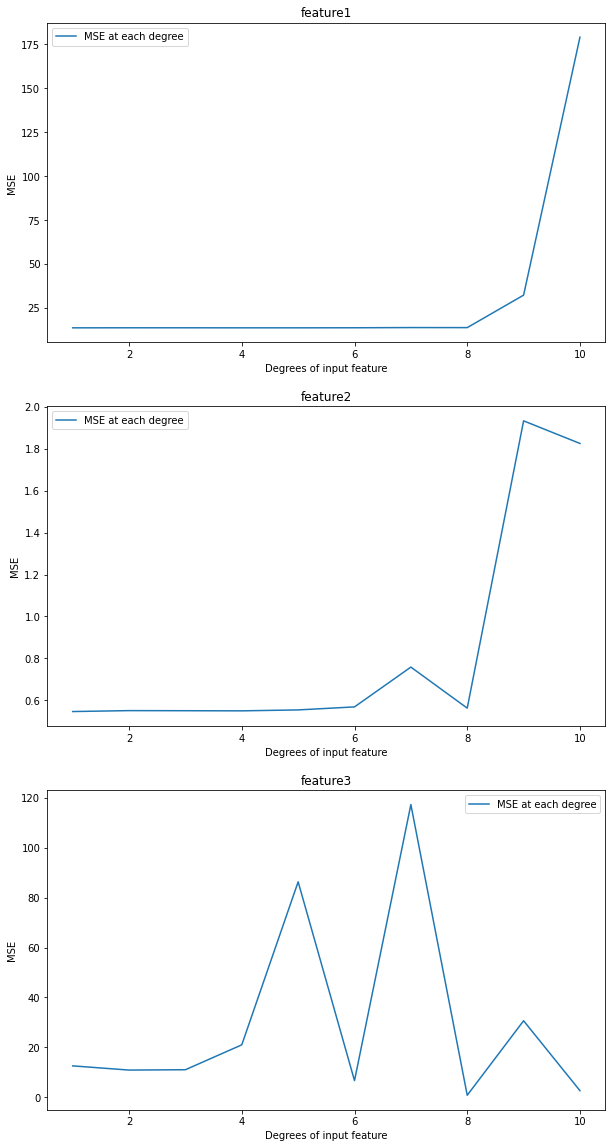

In [8]:
fig, axes = plt.subplots(3, 1, figsize=(10, 20))

degrees = list(range(1, 11))

feature_losses = {}

for ii, column in enumerate(train_data.columns[1:]):

    val_losses = []
    for degree in degrees:
        pipe = make_pipeline(
            PolynomialFeatures(degree=degree),
            Ridge()
        )
        pipe.fit(train_data[['datetime']], train_data[[column]])
        prediction = pipe.predict(val_data[['datetime']])

        loss = mean_squared_error(y_true=val_data[column], y_pred=prediction)
        val_losses.append(loss)

    axes[ii].plot(degrees, val_losses, label="MSE at each degree")
    axes[ii].set_title(column)
    axes[ii].set_xlabel("Degrees of input feature")
    axes[ii].set_ylabel("MSE")
    axes[ii].legend()

    feature_losses[column] = val_losses

plt.show()

In [9]:
feature_degree = {}

for feature in train_data.columns[1:]:
    min_mse = np.min(feature_losses[feature])
    min_degree = np.argmin(feature_losses[feature]) + 1
    feature_degree[feature] = min_degree
    print(f"best polynomial degree for {feature}: {min_degree}, "
          f"mse loss: {min_mse}")

best polynomial degree for feature1: 1, mse loss: 13.595103601663133
best polynomial degree for feature2: 1, mse loss: 0.5469451804116435
best polynomial degree for feature3: 8, mse loss: 0.8041970722643291


Visualising best predictions of each feature


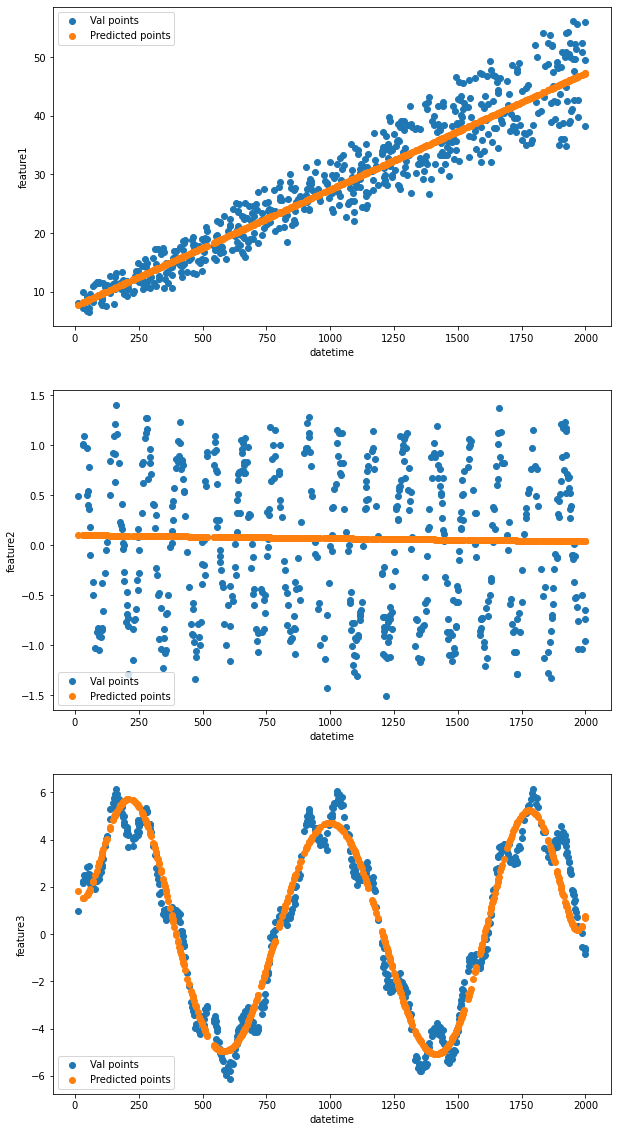

In [10]:
print('Visualising best predictions of each feature')

fig, ax = plt.subplots(3, 1, figsize=(10, 20))


for ii, (feature, degree) in enumerate(feature_degree.items()):
    pipe = make_pipeline(
        PolynomialFeatures(degree=degree),
        Ridge()
    )
    pipe.fit(train_data[['datetime']], train_data[[feature]])
    prediction = pipe.predict(val_data[['datetime']])

    ax[ii].scatter(val_data[['datetime']], val_data[[feature]],
                   label="Val points")
    ax[ii].scatter(val_data[['datetime']], prediction,
                   label="Predicted points")
    ax[ii].set_xlabel("datetime")
    ax[ii].set_ylabel(feature)
    ax[ii].legend()

plt.show()
fig.savefig('../figures/data-inputing-prediction.png')

For feature1 the best regression degree is 1:
- As we could see on the picture, the feature1 spread linearly, and thus the model shows that linear model with a degree of 1 ($\hat{y} = \theta_0 + \theta_1 * x$) approximates better than any other polynomial approximation).


For feature 2 the best regression degree is 1:
- As we could see on the picture, the data is not from polynomial distribution - we can not look at the distribution and tell the exact formula of it - it looks like sinus/cosine distribution and not linear for sure. Thus, the model also fails approximating the feature and chooses the most simple model - with degree 1 - not to have exploding coefficient while fitting the data and validating on it.

For feature 3 the best regression degree is 8:
- From the plot we could see that here we also have an unusual distribution - we can not say for sure the type of distribution. But looking for general form of curve - it is a curve with 5 extremum points - not too complex curve, and to make line going through this points we need at least 5 points ([Lagrange polynomial](https://en.wikipedia.org/wiki/Lagrange_polynomial)) - not too many points. So, 8 points should be enough to approximate data well, despite that the given points is not from polynomial distribution.